# Multi-Armed Bandits

Evaluate multiple system changes while maximizing business metrics

In [ ]:
import numpy as np
import scipy
import scipy.stats
import matplotlib as mpl
import matplotlib.pyplot as plt

In [15]:
arrow_props = {
    "width": 1,
    "color": "blue",
    "headwidth": 5,
    "headlength": 7,
}

In [28]:
def horizontal_line(y_0, clr=None):
    if clr is None:
        clr = "grey"
    c = plt.axis()
    plt.autoscale(False)
    plt.plot([c[0], c[1]], [y_0, y_0], "--", linewidth=1, color=clr)

## Epsilon-greedy: Account for the impact of evaluation on business metrics

### A/B testing as a baseline

Let's say the probability of a false positive stay below 0.05 and the probability of false negative stay below 0.20.

These limits---0.05 and 0.20---became standard values long ago in practical experiment design. They are convenient because, as probabilities, they are unitless---that is, they don't reference any domain-specific quantities like CTR, dollars of revenue, etc.---and so may be applied across experiments from a broad range of fields. Additionally, the standardization of these probability limits makes it easier to communicate results from one experimenter to another, as all experimenters build an intuition for the quality of results that is implied by 0.05 and 0.20.

When optimizing an engineered system, we want to increase a business metric, like CTR. An A/B test would increase CTR by

1.  Determining via experiment whether version A of your click model has a better or worse CTR than version B does, then
2.  Running the better version from now on

Step 2 produces a high CTR---the maximum of A's CTR and B's CTR. We won't change that.

Taking a measurement of version A or B (in step 1) means exposing real users to it and getting or losing their clicks, so what you choose to measure has real impact on your bottom line. Knowing that, let's modify step 1 so that during the experiment we more often measure whichever version (A or B) has a higher CTR. Our goal is to take as many measurements of the better version as we can while still taking *enough* measurements of the worse version to be sure it's worse.

To get started, let's create a simulation of the ad-selection system. We'll call the current version of the click model A (as usual) and simulate it so that the system produces a CTR of 0.005 (one half of 1%). According to the stats reported by LinkedIn (<http://mng.bz/gRzE>) for 2019, a CTR of 0.0050 for banner ads is a bit below the average of 0.0060 (0.60%). Knowing that, we propose a new click model, B, that we hope is better. For the purpose of presentation, we'll simulate the system with B so that it produces a CTR of 0.0070, above the industry average. See the following listing for the Python code that implements the simulation.

In [2]:
# Simulate measurement of click on an ad
def measure_click(ctr):
    return 1 if np.random.uniform(0,1) < ctr else 0

def measure_a():
    return measure_click(ctr=0.0050)

def measure_b():
    return measure_click(ctr=0.0070)

The function measure_click() returns the value 1 to simulate the event "the user clicked on the ad" or the value 0 to simulate "the user didn't click on the ad." It returns 1 with probability ctr. The expectation of measure_click(ctr) is the value ctr---that is, if we could take the average of infinitely many return values of measure_click(ctr), that average would be ctr. As such, the expected value of measure_A() is .0050 and the expected value of measure_B() is .0070. Or we could say, "The expected CTR of version A is .0050" (and similarly for B).

Next, let's simulate an A/B test following the steps:

1.  Run a pilot study to measure sd_1_delta, which we'll abbreviate as sd_1 here.
2.  Define a practical significance level, prac_sig.
3.  Calculate the number of individual measurements to take, num_ind.

An individual measurement consists of displaying a single ad and recording whether it was clicked on. See the following listing for the A/B test design. Let's take prac_sig = 0.001. Given that 0.0050 is our current CTR, an improvement of 0.001 would mean 20% more revenue per day.

In [3]:
# Design an A/B test
def design_ab_test():
    def pilot_study(num_pilot_measurements):
        clicked_pre_a = np.array([measure_a() for _ in range(num_pilot_measurements)])
        clicked_pre_b = np.array([measure_b() for _ in range(num_pilot_measurements)])
        sd_1 = np.sqrt( clicked_pre_a.std()**2 + clicked_pre_b.std()**2 )  
        return sd_1
    
    sd_1 = pilot_study(1000)
    prac_sig = 0.001    
    num_ind = (2.48 * sd_1 / prac_sig) ** 2
    return int(num_ind)

The design of an A/B test comes down to the prescription of how many individual measurements to take. For this scenario, we need:

In [4]:
np.random.seed(17)
design_ab_test()

91561

This produces num_ind = 91561, nearly 100,000, individual measurements. If you don't work in online advertising, that might seem like a lot of measurements, but consider that if 0.5% of 100,000 users clicked on an ad, your site would earn only $500. Since CTRs are small, you need to show lots of ads to sustain a business.

Simulating the A/B test is straightforward: For each individual measurement, we'll randomize between A and B. See below listing for the code. The randomization is taken care of by the condition `np.random.uniform(0,1) < 0.5`, where a random number chosen with uniform probability between 0 and 1 is less than 0.5 with probability 0.5. In other words, choose A half the time and choose B half the time.

In [5]:
# Simulate a run of an A/B test
def run_ab_test(num_ind):
    clicked_a = []
    clicked_b = []
    for n in range(num_ind):
        # Randomize between A and B.
        if np.random.uniform(0,1) < 0.5:
            clicked = measure_a()
            clicked_a.append(clicked)
        else:
            clicked = measure_b()
            clicked_b.append(clicked)

    clicked_a = np.array(clicked_a)
    clicked_b = np.array(clicked_b)
    
    return clicked_a, clicked_b

To complete the experiment, we would run an analysis like below, where we compute the z score from the logged data, clicked_a and clicked_b.

In [6]:
# Analyze the A/B test data
def analyze_a_b_test(clicked_a, clicked_b):   
    mean_a = clicked_a.mean()
    mean_b = clicked_b.mean()
    std_a = clicked_a.std()
    std_b = clicked_b.std()
    m = mean_b - mean_a
    se = np.sqrt((std_a**2 + std_b**2) / num_ind)
    z = m / se
    
    return z

In [7]:
np.random.seed(17)
num_ind = design_ab_test()
clicked_A, clicked_B = run_ab_test(num_ind)
z = analyze_a_b_test(clicked_A, clicked_B)
print(num_ind, z)

91561 2.954555022088617


This yields z = 2.95. Since z > 1.64, we would accept the change and replace model A with model B.

Before the A/B test ran, the production system used model A, which produced a CTR of 0.0050. After the A/B test completed, the system would have used B, which produces CTR = 0.0070. During the A/B test, however, the system was randomizing between A and B, using each version half of the time. The CTR achieved by the system during the A/B test is, thus, just the average of A's and B's CTRs, or (0.0050 + 0.0070)/2 = 0.0060.

We couldn't have known B was better than A until after we ran the A/B test, but now that we know, we can look back and say that if we had run B instead of running an A/B test, we could have earned CTR = 0.0070 instead of the A/B test's CTR = 0.0060. The term used in multi-armed bandit literature to describe this lost opportunity is *regret*. We say that the A/B test produced a regret of:

```
CTR of model B - CTR of the A/B test = 0.0070 - 0.0060 = 0.0010
```

We missed out on 0.0010 CTR by running the A/B test instead of running model B.

Let's delve deeper to understand how the CTR evolves while the A/B test is running. Listing below runs the A/B test again but instruments it to count the number of ads displayed and the number of ads that are clicked on. clicked_a and clicked_b have been removed in favor of counting the number of ads and clicks for A and B separately.

In [8]:
# Trace the CTR as the A/B test runs
def ab_test(num_ind):
    sum_clicks = 0.0
    num_ads = 0.0
    sum_a = 0.0
    num_a = 0
    sum_b = 0.0
    num_b = 0

    ctr_vs_n = []
    ctr_a = []
    ctr_b = []
    for n in range(num_ind):
        if np.random.uniform(0,1) < 0.5:
            clicked = measure_a()
            sum_a += clicked
            num_a += 1
        else:
            clicked = measure_b()
            sum_b += clicked
            num_b += 1
        sum_clicks += clicked
        num_ads += 1
        if num_a > 0 and num_b > 0:
            ctr_a.append(sum_a/num_a)
            ctr_b.append(sum_b/num_b)
            ctr_vs_n.append(sum_clicks/num_ads)            
    
    return ctr_vs_n, ctr_a, ctr_b

In [9]:
np.random.seed(17)
ctr_vs_n, ctr_a, ctr_b = ab_test(num_ind)

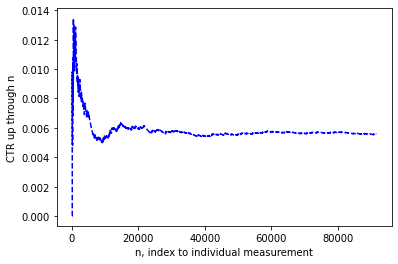

In [10]:
plt.plot(ctr_vs_n, '--', color="blue");
plt.xlabel('n, index to individual measurement')
plt.ylabel('CTR up through n');
plt.show()

The trace of CTR in the above figure fluctuates wildly initially---when fewer samples are included in it---then settles down to a final value of about 0.0058, which is close to the expected value of 0.0060. Running ab_test() 100 times produces final CTR values with mean 0.0060 and standard deviation 0.0002. Figure below shows the mean and standard deviation of all 100 traces.

In [11]:
def run_multi(trace_fn, num=100):
    traces = []
    n = 1e99
    for _ in range(num):
        trace = trace_fn()
        n = min(n, len(trace))
        traces.append(trace)

    traces_aligned = []
    for t in traces:
        traces_aligned.append(t[-n:])
    traces = np.array(traces_aligned)

    means = traces.mean(axis=0)
    stds = traces.std(axis=0)
    
    return means, stds

In [12]:
np.random.seed(17)
means_ab, stds_ab = run_multi(lambda: ab_test(num_ind)[0], 100)
print(means_ab[-1], stds_ab[-1])

0.00602418060091087 0.00026882061258969557


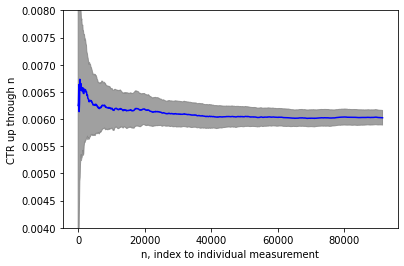

In [14]:
n = np.arange(len(means_ab))[::100]
plt.fill_between(n,
                 (means_ab-stds_ab/2)[::100],
                 (means_ab+stds_ab/2)[::100],
                 color="grey", alpha=.75, linewidth=1)

plt.plot(n, means_ab[::100], '-', color="blue")
c = plt.axis()
plt.xlabel('n, index to individual measurement')
plt.ylabel('CTR up through n');
plt.axis([c[0], c[1], .0040, .0080]);
plt.show()

The second and third outputs for ab_test()---ctr_a and ctr_b---trace the CTR up through measurement n for A and B separately. For example, ctr_a traces the CTR only for ads selected using click model A, and similarly for ctr_b. These two traces, plotted in figure below, let us see how each version's CTR measurement evolves over time and how they compare.

0.0051003727195448895 0.006085547918217241


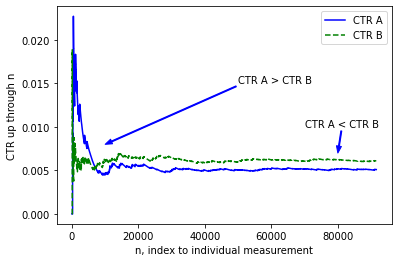

In [16]:
plt.plot(ctr_a, '-', color="blue");
plt.plot(ctr_b, '--', color="green");
print(ctr_a[-1], ctr_b[-1])
plt.xlabel('n, index to individual measurement')
plt.ylabel('CTR up through n');
plt.legend(['CTR A', 'CTR B'])
plt.annotate("CTR A > CTR B", xy=[10000, .0080],
             xytext=[50000, .015],
             arrowprops=arrow_props
            )
plt.annotate("CTR A < CTR B", xy=[80000, .0070],
             xytext=[70000, .010],
             arrowprops=arrow_props
            )
plt.show()

If I were running this A/B test and monitoring CTR A and CTR B, I might be tempted to stop around n = 100.000 or so. Seeing B consistently outperform A would make me want to accept B so that the system would earn B's CTR of 0.0070, rather than the blended CTR of 0.0050. But I know stopping an A/B test early generates false positives.

This tension between wanting to capitalize on the higher-performing B version as soon as possible and the desire to avoid a false-positive acceptance can be resolved by modifying A/B testing's randomization procedure to preferentially choose the better of A and B. This proposal is the epsilon-greedy algorithm, and it is one solution to the multi-armed bandit problem.

### 3.1.2	The epsilon-greedy algorithm

Instead of choosing between A and B with equal probability, p(A) = p(B) = 0.5, epsilon-greedy assigns a higher probability to whichever version, A or B, has produced a higher CTR so far.

Epsilon-greedy works like this: With probability 1-epsilon, use whichever version has a higher CTR so far. Otherwise, with probability epsilon, act like an A/B test and just choose between A and B with equal probability.

To convert A/B test logic to epsilon-greedy logic.

Notice that if we set epsilon = 1, then the first branch is never executed because np.random.uniform(0,1) is never less than 1 - epsilon = 0. Similarly, if we set epsilon = 0, the second branch is never executed. The value of epsilon determines how strongly epsilon-greedy's randomization is biased toward the higher-CTR version of the system. In addition, epsilon is a parameter of the epsilon-greedy algorithm, not a parameter of the system itself. To make that distinction clear, we refer to epsilon as a metaparameter.

In [17]:
# The epsilon-greedy algorithm
def epsilon_greedy(num_ind, epsilon):
    sum_clicks = 0.0
    num_ads = 0.0
    sum_a = 0.0
    num_a = 0
    sum_b = 0.0
    num_b = 0
    ctr_vs_n = []
    used_b = []
    for _ in range(int(num_ind)):
        select = "Randomize"
        if np.random.uniform(0,1) < 1-epsilon:
            ctr_a = sum_a/num_a if num_a>0 else 0
            ctr_b = sum_b/num_b if num_b>0 else 0
            if ctr_a > ctr_b:
                select = "A"
            elif ctr_b > ctr_a:
                select = "B"
            # else, if they're equal, randomize
            
        if select == "Randomize":
            if np.random.uniform(0,1) < 0.5:
                select = "A"
            else:
                select = "B"
                
        if select == "A":
            clicked = measure_a()
            sum_a += clicked
            num_a += 1
            used_b.append(False)
        else:
            clicked = measure_b()
            sum_b += clicked
            num_b += 1
            used_b.append(True)
        sum_clicks += clicked
        num_ads += 1
        
        ctr_vs_n.append(sum_clicks / num_ads)
    
    return ctr_vs_n, used_b

In [18]:
np.random.seed(17)
ctr_eps_greedy = epsilon_greedy(num_ind=num_ind, epsilon=0.1)[0]
print(ctr_eps_greedy[-1])

0.007164622492109086


As shown, epsilon_greedy() computes summary statistics---ctr_a and ctr_b---and uses them to make a better decision about which version, A or B, to use for each individual measurement. In this way, epsilon-greedy is adaptive (i.e., it modifies its decisions based on the data it has seen so far). In contrast, A/B testing does not adapt to the data. It always randomizes between A and B equally.

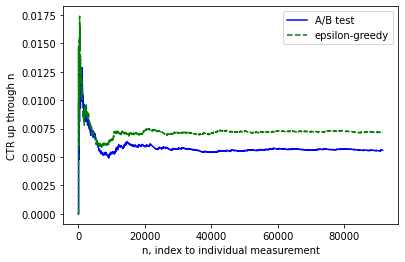

In [19]:
plt.plot(ctr_vs_n, '-', color="blue");
plt.plot(ctr_eps_greedy, '--', color="green");
plt.xlabel('n, index to individual measurement')
plt.ylabel('CTR up through n');
plt.legend(['A/B test', 'epsilon-greedy'])
plt.show()

The epsilon-greedy algorithm achieves a higher CTR (about .0067) than an A/B test (about .0058) by using whichever version—A or B—has better realized performance 90% of the time and only 10% of time randomly choosing between A and B.

In [20]:
np.random.seed(17)
means_eg, stds_eg = run_multi(lambda: epsilon_greedy(num_ind, .1)[0], 100)
print(means_eg[-1], stds_eg[-1])

0.006726444665305099 0.0004502734349471643


Figure below shows 100 runs of ab_test() compared to 100 runs of epsilon_greedy(): epsilon_greedy() consistently achieves higher CTR. The final, mean CTR of epsilon_greedy() is 0.0068, which is close to the maximum of 0.0070, the CTR of B.

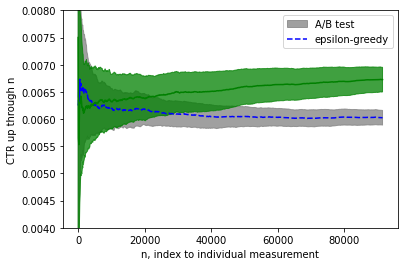

In [21]:
means_eg_tr = means_eg[-len(means_ab):]
stds_eg_tr = stds_eg[-len(stds_ab):]
n = np.arange(len(means_ab))[::100]

plt.fill_between(n,
                 (means_ab-stds_ab/2)[::100],
                 (means_ab+stds_ab/2)[::100],
                 color="grey", alpha=.75, linewidth=1)
plt.plot(n, means_ab[::100], '--', color="blue")

plt.fill_between(n,
                 (means_eg_tr-stds_eg_tr/2)[::100],
                 (means_eg_tr+stds_eg_tr/2)[::100],
                 color="green", alpha=.75, linewidth=1)
plt.plot(n, means_eg_tr[::100], '-', color="green")



c = plt.axis()
plt.xlabel('n, index to individual measurement')
plt.ylabel('CTR up through n');
plt.legend(['A/B test','epsilon-greedy'])
plt.axis([c[0], c[1], .0040, .0080]);
plt.show()

Figure below compares the percentage of the 100 runs in which B is selected for measurement to that in which A is selected.

In [22]:
def run_multi_selection_rates(selected_fn, num=100):
    selected = []
    for _ in range(num):
        selected.append(selected_fn())

    selected = np.array(selected)
    indices = np.unique(selected)
    rate_selected = []
    for i in indices:
        chis = selected==i
        rate_selected.append(chis.mean(axis=0))
    rate_selected = np.array(rate_selected)
    
    return indices, rate_selected

In [23]:
indices, rate_selected = run_multi_selection_rates(lambda: epsilon_greedy(num_ind, .1)[-1], 100)
print(indices)

[False  True]


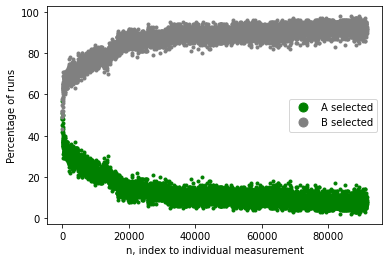

In [24]:
n = np.arange(rate_selected.shape[1])
plt.plot(n[::10], 100*rate_selected[0,:][::10], '.', color="green");
plt.plot(n[::10], 100*rate_selected[1,:][::10], '.', color="grey");
plt.legend(['A selected', 'B selected'], markerscale=3)
plt.ylabel('Percentage of runs')
plt.xlabel('n, index to individual measurement')
plt.show()

### Deciding when to stop

In our formulation of the epsilon-greedy algorithm so far, there is no prescription to stop exploring. In the preceding simulations, we chose num_ind, the number of measurements, using A/B test design so that we could compare A/B testing to epsilon-greedy. But if you chose to use epsilon-greedy in practice, there would be no natural point at which you'd make an acceptance/rejection decision. The A/B test-designed num_ind value doesn't apply here, because it was chosen to limit false positives and negatives. Instead, the goal with epsilon-greedy is to maximize a business metric, like CTR.

We can get epsilon-greedy to stop with a slight modification to the algorithm:

In [25]:
# Epsilon-greedy with decaying epsilon
def epsilon_greedy_decay():
    bm_max = 0.01
    prac_sig = 0.001
    c = 5
    
    epsilon_0 = 2*c*(bm_max/prac_sig)**2
    epsilon_stop = 0.01
    
    sum_clicks = 0.0
    num_ads = 0.0
    sum_a = 0.0
    num_a = 0
    sum_b = 0.0
    num_b = 0
    ctr_vs_n = []
    epsilons = []
    
    n = 0
    selected = None
    while True:
        epsilon = min(1.0, epsilon_0 / (1.0 + n))
        epsilons.append(epsilon)
        if epsilon < epsilon_stop:
            break
        select = "Randomize"
        if np.random.uniform(0,1) < 1-epsilon:
            ctr_a = sum_a/num_a if num_a>0 else 0
            ctr_b = sum_b/num_b if num_b>0 else 0
            if ctr_a > ctr_b:
                select = "A"
                selected = "A"
            elif ctr_b > ctr_a:
                select = "B"
                selected = "B"
        if select == "Randomize":
            if np.random.uniform(0,1) < 0.5:
                select = "A"
            else:
                select = "B"

        if select == "A":
            clicked = measure_a()
            sum_a += clicked
            num_a += 1
        else:
            clicked = measure_b()
            sum_b += clicked
            num_b += 1
        sum_clicks += clicked
        num_ads += 1
        
        ctr_vs_n.append(sum_clicks / num_ads)
        n += 1

    if selected == "B":
        accept_reject = "Accept"
    else:
        accept_reject = "Reject"
    return ctr_vs_n, epsilons, accept_reject

In [26]:
np.random.seed(17)
ctr_eps_greedy_decay, epsilons, accept_reject = epsilon_greedy_decay()
print(len(ctr_eps_greedy_decay), ctr_eps_greedy_decay[-1], accept_reject)

100000 0.00714 Accept


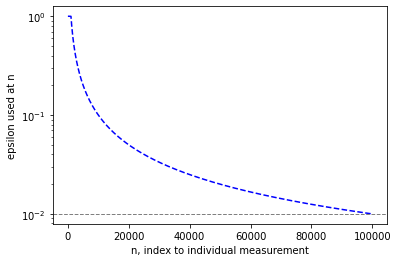

0.00999990000099999

In [29]:
plt.semilogy(epsilons, '--', color="blue");
plt.xlabel('n, index to individual measurement')
plt.ylabel('epsilon used at n');
horizontal_line(.01)
plt.show()
epsilons[-1]

## Evaluate multiple system changes simultaneously

In [30]:
def run_multi_ragged(trace_fn, num=100):
    finals = []
    for _ in range(num):
        trace = trace_fn()
        finals.append(trace[-1])
    finals = np.array(finals)
    mean = finals.mean()
    std = finals.std()
    
    return mean, std

In [31]:
np.random.seed(17)
mean_selected, std_selected = run_multi_ragged(lambda: [int(epsilon_greedy_decay()[-1] == "Accept")], 100)
print(mean_selected, std_selected)

0.96 0.19595917942265423


In [32]:
def epsilon_greedy_decay_compare(num_ind):
    # Run for N measurements ignoring epsilon_stop
    
    bm_max = 0.01
    prac_sig = 0.001
    
    epsilon_0 = 2*5*(bm_max/prac_sig)**2
    
    sum_clicks = 0.0
    num_ads = 0.0
    sum_a = 0.0
    num_a = 0
    sum_b = 0.0
    num_b = 0
    ctr_vs_n = []
    epsilons = []
    
    selected = None
    for n in range(num_ind):
        epsilon = min(1.0, epsilon_0 / (1.0 + n))
        epsilons.append(epsilon)
        select = "Randomize"
        if np.random.uniform(0,1) < 1-epsilon:
            ctr_a = sum_a/num_a if num_a>0 else 0
            ctr_b = sum_b/num_b if num_b>0 else 0
            if ctr_a > ctr_b:
                select = "A"
                selected = "A"
            elif ctr_b > ctr_a:
                select = "B"
                selected = "B"
            
            # else, if they're equal, randomize
            
        if select == "Randomize":
            if np.random.uniform(0,1) < 0.5:
                select = "A"
            else:
                select = "B"
                
        if select == "A":
            clicked = measure_a()
            sum_a += clicked
            num_a += 1
        else:
            clicked = measure_b()
            sum_b += clicked
            num_b += 1
        sum_clicks += clicked
        num_ads += 1
        
        ctr_vs_n.append(sum_clicks / num_ads)

    if selected == "B":
        accept_reject = "Accept"
    else:
        accept_reject = "Reject"
    return ctr_vs_n, epsilons, accept_reject

In [33]:
np.random.seed(17)
means_eg_dc, stds_eg_dc = run_multi(lambda: epsilon_greedy_decay_compare(num_ind)[0], 100)
print(means_eg_dc[-1], stds_eg_dc[-1])

0.006793394567556058 0.0005296632156451808


In [34]:
np.random.seed(17)
mean_selected, std_selected = run_multi(lambda: [int(epsilon_greedy_decay_compare(num_ind)[-1]=="Accept")], 100)
print(mean_selected, std_selected)

[0.95] [0.21794495]


In [35]:
# Simulate several click models
def measure_arm(i_arm):
    return measure_click(ctr=.005 + i_arm*.002)

In [36]:
# Epsilon-greedy with four arms
def epsilon_greedy_decay_multi():
    bm_max = 0.01
    prac_sig = 0.001
    k = 4
    c = 5
    
    epsilon_0 = k*c*(bm_max/prac_sig)**2
    epsilon_stop = 0.01
    
    sum_clicks = 0.0
    num_ads = 0.0
    sum_arm = [0.0]*k
    num_arm = [0.0]*k
    ctr_vs_n = []
    
    n = 0
    arms_selected = []
    while True:
        epsilon = min(1.0, epsilon_0 / (1.0 + n))
        if epsilon < epsilon_stop:
            break
        i_selected = None
        if np.random.uniform(0,1) < 1-epsilon:
            max_ctr = None
            for i in range(k):
                if num_arm[i] > 0:
                    ctr_arm = sum_arm[i] / num_arm[i]
                else:
                    ctr_arm = 0
                # break ties by randomizing
                ctr_arm += 1e-9 * np.random.normal()
                if max_ctr is None or ctr_arm > max_ctr:
                    max_ctr = ctr_arm
                    i_selected = i
            i_best_arm = i_selected
        else:
            i_selected = np.random.randint(k)
                
        arms_selected.append(i_selected)
        clicked = measure_arm(i_selected)
        sum_arm[i_selected] += clicked 
        num_arm[i_selected] += 1
        sum_clicks += clicked
        num_ads += 1
        
        ctr_vs_n.append(sum_clicks / num_ads)
        n += 1

    return ctr_vs_n, arms_selected

In [37]:
np.random.seed(17)
ctr_epsilon_greedy_decay_multi, arms_selected = epsilon_greedy_decay_multi()
print(len(ctr_epsilon_greedy_decay_multi), ctr_epsilon_greedy_decay_multi[-1], arms_selected[-1])

200000 0.01075 3


In [38]:
np.random.seed(17)
mean_egd, std_egd  = run_multi(lambda: epsilon_greedy_decay_multi()[0], 100)
print(mean_egd[-1], std_egd[-1])

0.010468999999999992 0.0007421738340847109


In [39]:
np.random.seed(17)
mean_selected, std_selected = run_multi(lambda: [int(epsilon_greedy_decay_multi()[-1][-1] == 3)], 100)
print(mean_selected, std_selected)

[0.81] [0.3923009]


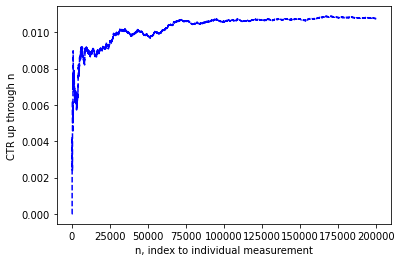

In [40]:
plt.plot(ctr_epsilon_greedy_decay_multi, '--', color="blue");
plt.xlabel('n, index to individual measurement')
plt.ylabel('CTR up through n');
plt.show()

In [41]:
indices_multi, rate_selected_multi = run_multi_selection_rates(lambda: epsilon_greedy_decay_multi()[-1], 100)
print(indices)

[False  True]


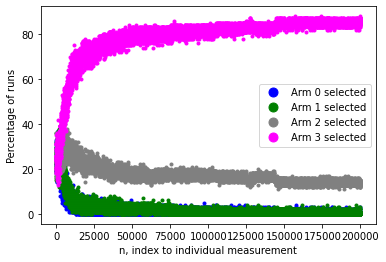

In [44]:
n = np.arange(rate_selected_multi.shape[1])[::10]
legend = []
colors = ["blue", "green", "grey", "magenta"]
for i in range(4):
    plt.plot(n, 100*rate_selected_multi[i,::10], '.', color=colors[i]);
    legend.append(f'Arm {i} selected')
plt.legend(legend, markerscale=3)
plt.ylabel('Percentage of runs')
plt.xlabel('n, index to individual measurement')

plt.show()

## Thompson Sampling: A more efficient bandit algorithm

Epsilon greedy is simple to implement, has optimal asymptotic regret, and does a good job of demonstrating the crux of the solution to the multi-armed bandit problem: the need to trade off exploration with exploitation.

But we can do better. With a little effort, we can construct an MAB algorithm that produces higher CTR while it runs, stops sooner, and doesn't have a system-dependent metaparameter like c.

Thompson sampling calculates the probability that each click model (each arm) will be the best one, call it pbest(arm). The rule of Thompson sampling is that when it's time to take an individual measurement, you randomize over the arms such that the probability of measuring an arm is equal to the probability that it is the best arm.

This rule is a *randomized probability matching* rule. The choice of arm to measure is randomized (so that we explore), but better-seeming arms get run more often (so we also exploit). This is an elegant way to effect the exploration-exploitation tradeoff. Estimation of the probability that an arm is the best, pbest(arm), is the core calculation of Thompson sampling.

### Estimating the probability that an arm is the best

In [45]:
I_clicked = np.array([0,0,1,0,1,1,0,0,1,0])

In [46]:
ctr = I_clicked.mean()
print(ctr)

0.4


In [47]:
se = I_clicked.std() / np.sqrt(len(I_clicked))
print(se)

0.15491933384829668


In [48]:
# Generate a bootstrap sample from a data set
def bootstrap_sample(data):
    n = len(data)
    return data[np.random.randint(n, size=(n,))]

In [49]:
np.random.seed(17)
print(bootstrap_sample(I_clicked))
print(bootstrap_sample(I_clicked))
print(bootstrap_sample(I_clicked))

[0 0 0 0 0 0 1 0 1 0]
[0 0 0 1 1 0 0 0 0 0]
[0 1 0 0 1 0 0 1 0 0]


In [50]:
def replicate_means(data, num_replications):
    means = []
    for _ in range(num_replications):
        means.append(bootstrap_sample(data).mean())
    return np.array(means)

In [51]:
np.random.seed(17)
ctrs = replicate_means(I_clicked, 1000)
print(ctrs.mean())
print(ctrs.std())

0.39829999999999993
0.15055600286936419


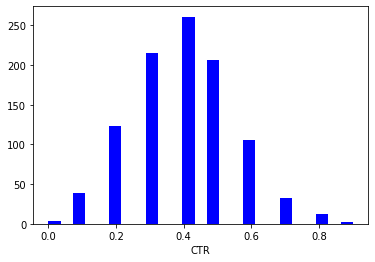

In [52]:
np.random.seed(17)
plt.hist(replicate_means(I_clicked, 1000), 25, color="blue");
plt.xlabel('CTR')
plt.show()

#### WORKING WITH FEW INDIVIDUAL MEASUREMENTS

<ipython-input-53-75c7b5dff7e6>:14: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([""]*len(locs))


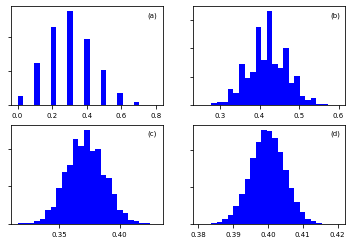

In [53]:
np.random.seed(17)
fig, axs = plt.subplots(2, 2)
i_axs = [(0,0), (0,1), (1,0), (1,1)]
letters = ["a", "b", "c", "d"]
num_measurements = 10
for i, i_ax in enumerate(i_axs):
    ax = axs[i_ax]
    ax.hist(replicate_means(np.random.binomial(n=1, p=.4, size=(int(num_measurements+.5),)),
                            10000), 25, color="blue");
    for label in ax.get_xticklabels():
        label.set_fontsize(7)
    
    locs = ax.get_yticks()
    ax.set_yticklabels([""]*len(locs))
    num_measurements *= 10
    c = ax.axis()
    ax.text(.1*c[0] + .90*c[1], .1*c[2] + .9*c[3], f"({letters[i]})", fontsize=7)

plt.show()

#### PROBABILITY OF BEING THE BEST ARM

In [54]:
np.random.seed(17)
I_clicked_1 = np.array([measure_click(ctr=.005) for _ in range(10000)])
I_clicked_2 = np.array([measure_click(ctr=.007) for _ in range(10000)])

In [55]:
print(I_clicked_1.mean())
print(I_clicked_2.mean())

0.0042
0.0057


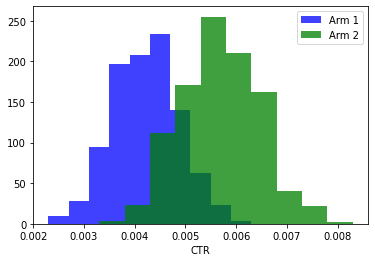

In [56]:
plt.hist(replicate_means(I_clicked_1, 1000), 10, color="blue", alpha=.75)
plt.hist(replicate_means(I_clicked_2, 1000), 10, color="green", alpha=.75);
plt.legend(['Arm 1', 'Arm 2'])
plt.xlabel('CTR')
plt.show()

In [57]:
# Estimate the probability of each arm being the better arm
def estimate_pbest(I_clicked_1, I_clicked_2):
    counts = [0, 0]
    num_samples = 100
    for _ in range(num_samples):
        ctr_1 = bootstrap_sample(I_clicked_1).mean()
        ctr_2 = bootstrap_sample(I_clicked_2).mean()
        if ctr_1 > ctr_2:
            counts[0] += 1
        elif ctr_2 > ctr_1:
            counts[1] += 1
        else:
            pass
            
    p_best = np.array(counts)/num_samples
    return p_best

In [58]:
np.random.seed(17)
estimate_pbest(I_clicked_1, I_clicked_2)

array([0.04, 0.95])

In [59]:
# Estimate the probability that each arm is best
def estimate_pbest(I_clickeds):
    counts = [0] * len(I_clickeds)
    num_samples = 100
    for _ in range(num_samples):
        ctrs = [bootstrap_sample(I_clicked).mean() for I_clicked in I_clickeds]
        ctrs = np.array(ctrs)
        i = np.where(ctrs == ctrs.max())[0]
        if len(i)==1:
            counts[i[0]] += 1
            
    return np.array(counts)/num_samples

In [60]:
np.random.seed(17)
I_clickeds = [None]*4
I_clickeds[0] = np.array([measure_click(ctr=.003) for _ in range(10000)])
I_clickeds[1] = np.array([measure_click(ctr=.005) for _ in range(10000)])
I_clickeds[2] = np.array([measure_click(ctr=.007) for _ in range(10000)])
I_clickeds[3] = np.array([measure_click(ctr=.009) for _ in range(10000)])
estimate_pbest(I_clickeds)

array([0.  , 0.  , 0.04, 0.94])

### Randomized Probability Matching

In [61]:
# Randomized probability matching
def rpm_select_arm(I_clickeds):
    ctrs = [bootstrap_sample(I_clicked).mean() for I_clicked in I_clickeds]
    ctrs = np.array(ctrs)
    i = np.where(ctrs == ctrs.max())[0]
    if len(i)!=1:
        return np.random.randint(len(I_clickeds))
    return i[0]

In [62]:
rpm_select_arm(I_clickeds)

2

#### ONLINE BOOTSTRAP

In [63]:
# Online Bootstrap
class OnlineBootstrap:
    def __init__(self, num_bs_means):
        self._sums = np.zeros(shape=(num_bs_means,))
        self._n = np.zeros(shape=(num_bs_means,))
        self._count = 0
        
    def append(self, clicked):
        i = np.where(np.random.randint(2, size=(len(self._n,))) == 0)[0]
        self._sums[i] += clicked
        self._n[i] += 1
        self._count += 1

    def CTR_estimate(self):
        i = np.random.randint(len(self._n))
        if self._n[i] == 0:
            return np.inf
        return self._sums[i] / self._n[i]
    
    def count(self):
        return self._count

In [64]:
# Randomized probability matching with the online bootstrap
def rpm_select_arm_ob(obs):
    ctrs = [ob.CTR_estimate() for ob in obs]
    ctrs = np.array(ctrs)
    i = np.where(ctrs == ctrs.max())[0]
    return np.random.choice(i)

In [65]:
# Estimate p_best with the online bootstrap
def estimate_pbest_ob(obs):
    counts = [0] * len(obs)
    num_samples = 100
    for _ in range(num_samples):
        ctrs = [ob.CTR_estimate() for ob in obs]
        ctrs = np.array(ctrs)
        i = np.where(ctrs == ctrs.max())[0]
        if len(i)==1:
            counts[i[0]] += 1
            
    return np.array(counts)/num_samples

### The complete algorithm

In [66]:
# Thompson sampling
def thompson_sampling():
    k = 4
    num_bs_means = 100
    p_stop = 0.95
    smallest_sum_difference = 1
    prac_sig = 0.001

    min_samples_per_arm = smallest_sum_difference / prac_sig
    
    obs = [OnlineBootstrap(num_bs_means) for _ in range(k)]
    sum_clicks = 0.0
    num_ads = 0.0
    ctr_vs_n = []

    n = 0
    while True:
        num_samples_per_arm = [ob.count() for ob in obs]
        i_too_few = np.where(np.array(num_samples_per_arm) < min_samples_per_arm)[0]
        if len(i_too_few) > 0:
            i_selected = np.random.choice(i_too_few)
        else:
            i_selected = rpm_select_arm_ob(obs)
        i_clicked = measure_arm(i_selected)
        obs[i_selected].append(i_clicked)
        sum_clicks += i_clicked
        num_ads += 1
        ctr_vs_n.append(sum_clicks / num_ads)

        n += 1
        if len(i_too_few) == 0 and n % 100 == 0:
            p_bests = estimate_pbest_ob(obs)
            i_best_arm = np.where(p_bests == p_bests.max())[0]
            if len(i_best_arm) == 1 and p_bests.max() >= p_stop:
                break
                
    return ctr_vs_n, i_best_arm        
    

In [67]:
np.random.seed(17)
ctr_ts, i_best_arm = thompson_sampling()
print(len(ctr_ts), ctr_ts[-1], i_best_arm)

6800 0.00926470588235294 [3]


In [68]:
np.random.seed(17)
mean_selected, std_selected = run_multi(lambda: [thompson_sampling()[1]==3], 100)
print(mean_selected, std_selected)

[[0.96]] [[0.19595918]]


In [69]:
def run_multi_count(trace_fn, num=100):
    nums = []
    for _ in range(num):
        trace = trace_fn()
        nums.append(len(trace))

    nums = np.array(nums)
    
    return nums.mean(), nums.max()

In [70]:
np.random.seed(17)
nums_mean, nums_max = run_multi_count(lambda: thompson_sampling()[0], 100)
print(nums_mean, nums_max)

20616.0 103500


In [71]:
def thompson_sampling_compare():
    k = 4
    num_bs_means = 100
    p_stop = 0.95
    smallest_sum_difference = 1
    prac_sig = 0.001

    min_samples_per_arm = smallest_sum_difference / prac_sig
    
    obs = [OnlineBootstrap(num_bs_means) for _ in range(k)]
    sum_clicks = 0.0
    num_ads = 0.0
    ctr_vs_n = []

    n = 0
    accepted = False
    for _ in range(200000):
        if accepted:
            i_selected = i_best_arm
        else:
            num_samples_per_arm = [ob.count() for ob in obs]
            i_too_few = np.where(np.array(num_samples_per_arm) < min_samples_per_arm)[0]
            if len(i_too_few) > 0:
                i_selected = np.random.choice(i_too_few)
            else:
                i_selected = rpm_select_arm_ob(obs)
                
        i_clicked = measure_arm(i_selected)
        obs[i_selected].append(i_clicked)
        sum_clicks += i_clicked
        num_ads += 1
        ctr_vs_n.append(sum_clicks / num_ads)

        n += 1
        if not accepted and len(i_too_few) == 0 and n % 100 == 0:
            p_bests = estimate_pbest_ob(obs)
            i_best_arm = np.where(p_bests == p_bests.max())[0]
            if len(i_best_arm) == 1 and p_bests.max() >= p_stop:
                i_best_arm = i_best_arm[0]
                accepted = True
                
    return ctr_vs_n, i_best_arm

In [72]:
np.random.seed(17)
mean_ts_compare, std_ts_compare = run_multi(lambda: thompson_sampling_compare()[0], 100)
print(mean_ts_compare[-1], std_ts_compare[-1])

In [ ]:
mean_egd_tr = mean_egd
std_egd_tr = std_egd

means_ts_tr = mean_ts_compare
stds_ts_tr = std_ts_compare

n = np.arange(len(mean_egd_tr))[::100]

plt.fill_between(n,
                 (mean_egd_tr-std_egd_tr/2)[::100],
                 (mean_egd_tr+std_egd_tr/2)[::100],
                 color="green", alpha=.75, linewidth=1)
plt.plot(n, mean_egd_tr[::100], '--', color="green")

nts = np.arange(len(means_ts_tr))[::100]  # TODO
plt.fill_between(nts,
                 (means_ts_tr-stds_ts_tr/2)[::100],
                 (means_ts_tr+stds_ts_tr/2)[::100],
                 color="grey", alpha=.75, linewidth=1)
plt.plot(nts, means_ts_tr[::100], '-', color="blue")

c = plt.axis()
plt.xlabel('n, index to individual measurement')
plt.ylabel('CTR up through n');
plt.legend(['epsilon-greedy', 'Thompson sampling'], loc='lower right')
plt.axis([c[0], c[1], .007, .011]);

plt.show()

## Summary

-   Multi-armed bandit algorithms reduce the cost of experimental optimization by trading off business metric improvement (exploitation) with evaluation of system versions (exploration).

-   Epsilon-greedy is an MAB algorithm that is simple to implement and has optimal asymptotic regret but requires the engineer to tune a system-specific metaparameter.

-   MAB algorithms make it easy to evaluate multiple versions---also called *arms*---simultaneously.

-   Thompson sampling produces better business metrics during operation than epsilon-greedy and has no system-dependent metaparameter to tune.